In [ ]:
import tensorflow as tf
import numpy as np
import keras
from keras.datasets import mnist
import sys
import matplotlib.pyplot as plt

# Vanilla pixel CNN

No horizontal/vertical stacking. No gating.

In [2]:
class pixelcnn:
    
    # Building an initializer
    def __init__(self,
                 batchsize=16,
                 width=28,
                 height=28,
                 num_res_blocks=2,
                 num_filters=32,
                 output_channel=16,
                 input_channel=1,
                 kernel_size=3):
        
        # Network architecture parameter
        self.batchsize=batchsize
        self.width=width
        self.height=height
        self.num_res_blocks=num_res_blocks
        self.num_filters=num_filters
        self.output_channel=output_channel
        self.input_channel=input_channel
        self.kernel_size = kernel_size
        
        tf.reset_default_graph()
        self.built = False
        config = tf.ConfigProto()
        config.gpu_options.allow_growth=True
        self.sesh = tf.Session(config=config)
        self.ops = self.build()
        self.sesh.run(tf.global_variables_initializer())    

    # Building a graph
    def build(self):
        if self.built: return -1
        else: self.built = True
        
        # Input image
        x = tf.placeholder(tf.float32, shape=[None, self.height, self.width, self.input_channel])
        y = tf.placeholder(tf.float32, shape=[None, self.height, self.width, self.output_channel])
        
        # Get the first layer out
        maskA = tf.constant(getMask(self.input_channel, self.num_filters*2, size=self.kernel_size, masktype="A"), dtype=tf.float32)
        kernel = tf.get_variable("kernel", shape=[self.kernel_size, self.kernel_size, self.input_channel, self.num_filters*2], initializer=tf.contrib.layers.xavier_initializer())
        layer = tf.nn.conv2d(x, kernel*maskA, strides=[1,1,1,1], padding="SAME")
        
        # Residual network here
        for i in range(self.num_res_blocks):
            layer = self.resiual_block(layer, i)
            
        layer = tf.nn.relu(layer)
        kernel = tf.get_variable("kernel2", shape=[1, 1, self.num_filters*1, self.num_filters*1], initializer=tf.contrib.layers.xavier_initializer())
        layer = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding="SAME")
        
        layer = tf.nn.relu(layer)
        kernel = tf.get_variable("kernel3", shape=[1, 1, self.num_filters*1, self.output_channel*1], initializer=tf.contrib.layers.xavier_initializer())
        logits = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding="SAME")
        predictions = tf.nn.softmax(logits)
        
        # Cost
        with tf.name_scope("cost"):
            temps = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=logits, axis=-1)
            cost = tf.reduce_mean(temps, axis=[0,1,2])
        
        # Optimization
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            optimizer = tf.train.AdamOptimizer(0.00005)
            tvars = tf.trainable_variables()
            grads_and_vars = optimizer.compute_gradients(cost, tvars)
            clipped = [(tf.clip_by_value(grad, -5, 5), tvar) for grad, tvar in grads_and_vars]
            train = optimizer.apply_gradients(clipped, name="minimize_cost")
        
        return dict(x=x,
                    y=y,
                    cost=cost,
                    train=train,
                    predictions=predictions)
    
    def resiual_block(self, _input, blocknum):
    
        with tf.variable_scope('resblock_'+str(blocknum)):
            # Saving input
            saved_input = _input

            # Projection down
            layer = tf.nn.relu(_input)
            kernel = tf.get_variable("kernel", shape=[1, 1, self.num_filters*2, self.num_filters*1], initializer=tf.contrib.layers.xavier_initializer())
            layer = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding="SAME")

            # Masked convolution
            layer = tf.nn.relu(layer)
            maskB = tf.constant(getMask(self.num_filters, self.num_filters, size=self.kernel_size, masktype="B"), dtype=tf.float32)
            kernel = tf.get_variable("kernel2", shape=[self.kernel_size, self.kernel_size, self.num_filters, self.num_filters], initializer=tf.contrib.layers.xavier_initializer())
            layer = tf.nn.conv2d(layer, kernel*maskB, strides=[1,1,1,1], padding="SAME")

            # Projection up
            layer = tf.nn.relu(layer)
            kernel = tf.get_variable("kernel3", shape=[1, 1, self.num_filters*1, self.num_filters*2], initializer=tf.contrib.layers.xavier_initializer())
            layer = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding="SAME")

            output = saved_input + layer
        return output
    
    def train(self, X, Y, steps):
        
        for s in range(steps):
            indicies  = np.random.choice(np.arange(X.shape[0]), self.batchsize)
            feed_dict = {self.ops["x"]: X[indicies],\
                         self.ops["y"]: Y[indicies]}
            
            ops_to_run = [self.ops["cost"],\
                          self.ops["train"],
                          self.ops["predictions"]]

            cost, _, preds = self.sesh.run(ops_to_run, feed_dict)
            sys.stdout.write("\rBatch: [%2d/%2d], loss: %.2f"%(s, steps, cost))
            
        return preds


In [3]:
# Mask shape implementation
def getMask(input_c, output_c, size=3, masktype="A"):
    assert size%2==1 and size>1
    if masktype == "A":
        m = np.zeros((size,size))
        m[:int(np.floor(size/2)), :] = 1
        m[int(np.floor(size/2)), :int(np.floor(size/2))] = 1
    elif masktype == "B":
        m = np.zeros((size,size))
        m[:int(np.floor(size/2)), :] = 1
        m[int(np.floor(size/2)), :int(np.floor(size/2))+1] = 1
    else:
        print("Error: no such masktype.")
    m2 = np.stack([m]*input_c, axis=-1)
    return np.stack([m2]*output_c, axis=-1)

In [4]:
def inference_histogram(network, nosample=False):
    nsamples = 16
    nbins = network.output_channel
    output = np.zeros((nsamples, network.width, network.height, nbins))
    for i in range(network.width):
        for j in range(network.height):
            temp = network.sesh.run(network.ops["predictions"], feed_dict={network.ops["x"]:output})
            if nosample:
                output[:,i,j,:] = temp[:,i,j,:]
            else:
                output[:,i,j,:] = np.eye(nbins)[np.array([np.random.choice(np.arange(0,nbins), p=temp[n,i,j,:]/np.sum(temp[n,i,j,:])) for n in range(nsamples)])]
    return output                                    

# No boundary, histogram based input

In [63]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.expand_dims(x_train, -1)
y = np.eye(16)[np.digitize(x_train, np.arange(16,256,16))]

In [64]:
network = pixelcnn(output_channel=16, input_channel=16, num_res_blocks=10)

In [65]:
x = network.train(y,y,10000)

Batch: [9999/10000], loss: 0.35

No sampling --> No variation

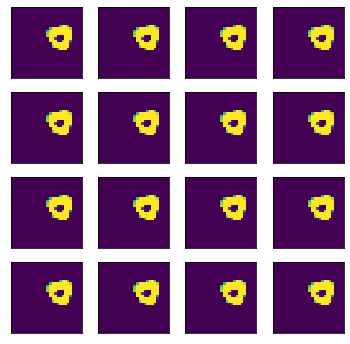

In [66]:
x = inference_histogram(network, True)

_, axes = plt.subplots(4,4,figsize=(6,6))
for i in range(4):
    for j in range(4):
        axes[i][j].imshow(np.argmax(x, -1)[i*4+j]*16)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
plt.show()

Sampling based

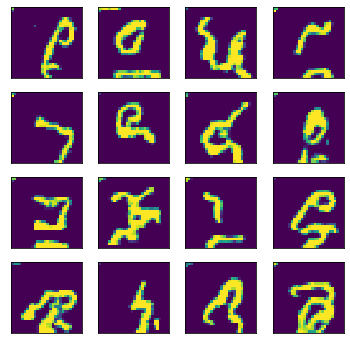

In [67]:
x = inference_histogram(network, False)

_, axes = plt.subplots(4,4,figsize=(6,6))
for i in range(4):
    for j in range(4):
        axes[i][j].imshow(np.argmax(x, -1)[i*4+j]*16)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
plt.show()

# Let us now have a complete boundary

May be the difference between 0 padding and 0 region of mnist needs to be more obvious?
Let us now add +1 to all image

In [68]:
# padding are 0. all pixels are +1
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.expand_dims(x_train, -1)
y = np.eye(17)[np.digitize(x_train, np.arange(16,256,16))+1]

In [69]:
network = pixelcnn(output_channel=17, input_channel=17, num_res_blocks=10)

In [70]:
x = network.train(y,y,10000)

Batch: [9999/10000], loss: 0.33

It is not quite there yet.

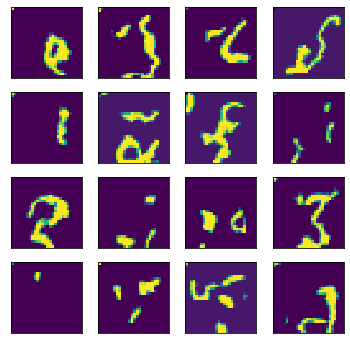

In [72]:
x = inference_histogram(network, False)

_, axes = plt.subplots(4,4,figsize=(6,6))
for i in range(4):
    for j in range(4):
        axes[i][j].imshow((np.argmax(x, -1)[i*4+j]-1)*16)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
plt.show()

# Expanding the pereptive field by deeper network
With convolution layer of size 3, the perceptive field only increase by 1 per layer.
There are two solutions; i) dilated convolution, or ii) make it deeper.


In [73]:
# padding are 0. all pixels are +1
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.expand_dims(x_train, -1)
y = np.eye(17)[np.digitize(x_train, np.arange(16,256,16))+1]

Perceptive field of 30

In [74]:
network = pixelcnn(output_channel=17, input_channel=17, num_res_blocks=30)

In [75]:
x = network.train(y,y,10000)

Batch: [9999/10000], loss: 0.35

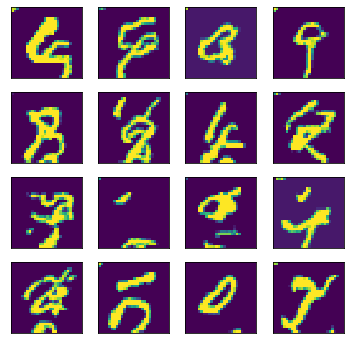

In [76]:
x = inference_histogram(network, False)

_, axes = plt.subplots(4,4,figsize=(6,6))
for i in range(4):
    for j in range(4):
        axes[i][j].imshow((np.argmax(x, -1)[i*4+j]-1)*16)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
plt.show()

# How can I make it better?
I mean this is a pretty large network for mnist generation already....
Ok so it looks like we need a lot more filters

In [6]:
# padding are 0. all pixels are +1
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.expand_dims(x_train, -1)
y = np.eye(17)[np.digitize(x_train, np.arange(16,256,16))+1]

In [5]:
network = pixelcnn(output_channel=17, input_channel=17, num_res_blocks=60, num_filters=64, kernel_size=5)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [8]:
x = network.train(y,y,30000)

Batch: [29999/30000], loss: 0.31

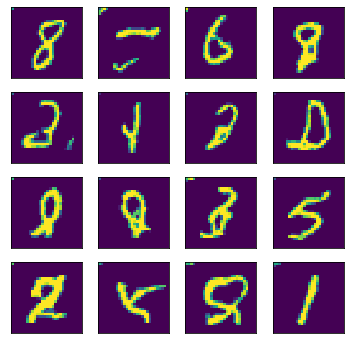

In [9]:
x = inference_histogram(network, False)

_, axes = plt.subplots(4,4,figsize=(6,6))
for i in range(4):
    for j in range(4):
        axes[i][j].imshow((np.argmax(x, -1)[i*4+j]-1)*16)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
plt.show()

# Let's do more filters m8

Less layers but four times more filters.

In [16]:
network = pixelcnn(output_channel=17, input_channel=17, num_res_blocks=30, num_filters=256, kernel_size=5)

In [ ]:
x = network.train(y,y,20000)

Batch: [5887/20000], loss: 0.29

In [ ]:
x = inference_histogram(network, False)

_, axes = plt.subplots(4,4,figsize=(6,6))
for i in range(4):
    for j in range(4):
        axes[i][j].imshow((np.argmax(x, -1)[i*4+j]-1)*16)
        axes[i][j].set_xticks([])
        axes[i][j].set_yticks([])
plt.show()